**Import Libraries**

In [32]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [33]:
dataset = read_csv('stock.csv',index_col=0)
print(dataset.shape)
set_option('display.width', 100)
dataset.head(5)

(4804, 64)


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NVDA,ORLY,ROST,T,TJX,TXN,UNP,UPS,WFC,K
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847,35.477,3.531,40.188,14.561,21.582,43.004,16.984,29.472,NaN,...,0.975,10.750,2.172,35.498,2.539,51.438,10.766,67.062,19.562,29.875
2000-01-04,28.661,34.134,3.233,40.125,14.372,21.582,40.577,17.041,31.198,NaN,...,0.949,9.969,2.078,33.421,2.406,49.250,10.750,64.938,18.594,28.812
2000-01-05,30.122,33.959,3.280,42.625,14.914,22.049,40.895,17.228,32.493,NaN,...,0.918,10.031,2.125,33.941,2.336,48.062,10.750,68.000,18.406,28.562
2000-01-06,31.877,33.959,2.996,43.062,15.459,22.903,39.782,17.210,31.198,NaN,...,0.858,9.469,1.898,33.044,2.477,46.750,11.406,68.000,19.219,28.812
2000-01-07,32.510,34.434,3.138,44.312,15.962,23.306,42.129,18.342,30.705,NaN,...,0.872,8.312,1.875,33.327,2.539,47.000,11.328,66.375,19.562,29.250


**Data Cleaning**

In [34]:
missing = dataset.isnull().mean().sort_values(ascending=False)
print(missing)
drop_list = sorted(list(missing[missing > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
print(dataset.shape)

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Keep data within 3 standard deviation
datareturns = datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

DWDP    0.924
V       0.429
MMM     0.000
JWN     0.000
FDX     0.000
        ...  
VZ      0.000
WMT     0.000
WBA     0.000
ADBE    0.000
K       0.000
Length: 64, dtype: float64
(4804, 62)


In [35]:
dataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NVDA,ORLY,ROST,T,TJX,TXN,UNP,UPS,WFC,K
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847,35.477,3.531,40.188,14.561,21.582,43.004,16.984,29.472,23.862,...,0.975,10.750,2.172,35.498,2.539,51.438,10.766,67.062,19.562,29.875
2000-01-04,28.661,34.134,3.233,40.125,14.372,21.582,40.577,17.041,31.198,23.405,...,0.949,9.969,2.078,33.421,2.406,49.250,10.750,64.938,18.594,28.812
2000-01-05,30.122,33.959,3.280,42.625,14.914,22.049,40.895,17.228,32.493,24.569,...,0.918,10.031,2.125,33.941,2.336,48.062,10.750,68.000,18.406,28.562
2000-01-06,31.877,33.959,2.996,43.062,15.459,22.903,39.782,17.210,31.198,25.959,...,0.858,9.469,1.898,33.044,2.477,46.750,11.406,68.000,19.219,28.812
2000-01-07,32.510,34.434,3.138,44.312,15.962,23.306,42.129,18.342,30.705,25.883,...,0.872,8.312,1.875,33.327,2.539,47.000,11.328,66.375,19.562,29.250


In [36]:
datareturns.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NVDA,ORLY,ROST,T,TJX,TXN,UNP,UPS,WFC,K
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.018,0.009,-0.051,-0.019,-0.016,-0.009,-3.005e-02,0.034,0.010,1.194e-02,...,-0.040,-0.015,-0.045,-0.014,-0.016,-0.009,0.008,-0.027,-0.017,0.022
2000-01-20,-0.037,0.017,0.065,-0.024,-0.044,-0.005,8.905e-04,0.010,-0.032,-2.186e-02,...,-0.003,0.000,0.064,0.011,0.003,0.031,-0.037,0.009,-0.010,-0.037
2000-05-12,-0.012,0.015,0.047,-0.003,0.015,0.010,-5.145e-03,-0.024,-0.008,-1.109e-02,...,-0.030,-0.031,0.026,-0.016,0.003,0.009,0.015,0.005,0.028,0.028
2000-05-18,-0.011,0.017,-0.006,0.007,-0.030,-0.005,-4.517e-02,0.025,-0.025,8.602e-04,...,-0.068,0.017,0.003,-0.023,0.019,0.001,0.013,-0.003,0.006,-0.005
2000-05-19,-0.029,-0.029,-0.067,-0.018,0.032,0.027,-3.503e-02,0.013,-0.003,3.683e-03,...,-0.008,-0.017,0.009,-0.035,0.025,-0.038,0.008,-0.004,-0.001,0.035


**Standardization (mean = 0, var = 1)**

In [37]:
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NVDA,ORLY,ROST,T,TJX,TXN,UNP,UPS,WFC,K
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.773,0.618,-2.885,-1.372,-1.106,-0.824,-1.960,3.773,0.783,1.018,...,-1.628,-1.114,-3.091,-1.238,-1.217,-0.559,0.560,-2.864,-1.169,2.293
2000-01-20,-3.696,1.161,3.502,-1.727,-3.002,-0.471,0.030,1.048,-2.551,-1.974,...,-0.155,-0.040,4.252,0.957,0.231,1.780,-2.853,0.936,-0.720,-3.913
2000-05-12,-1.258,1.046,2.495,-0.293,0.916,0.716,-0.358,-2.768,-0.622,-1.021,...,-1.235,-2.268,1.699,-1.398,0.237,0.505,1.098,0.510,1.994,2.919
2000-05-18,-1.096,1.181,-0.411,0.417,-2.040,-0.447,-2.932,2.727,-1.988,0.037,...,-2.699,1.184,0.153,-2.078,1.428,0.060,0.904,-0.342,0.420,-0.495
2000-05-19,-2.929,-2.051,-3.755,-1.349,2.082,2.121,-2.280,1.371,-0.267,0.287,...,-0.379,-1.244,0.558,-3.130,1.876,-2.248,0.578,-0.448,-0.097,3.607


In [38]:
set_option('precision', 3)
rescaledDataset.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NVDA,ORLY,ROST,T,TJX,TXN,UNP,UPS,WFC,K
count,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,...,3.280e+03,3280.000,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03,3.280e+03
mean,2.166e-17,-4.333e-18,4.874e-18,-2.166e-18,1.625e-17,6.499e-18,2.166e-18,-1.516e-17,-2.166e-18,7.582e-18,...,-1.516e-17,0.000,-4.333e-18,6.499e-18,1.950e-17,1.516e-17,6.499e-18,4.333e-18,1.300e-17,5.416e-18
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,...,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-4.071e+00,-4.606e+00,-3.931e+00,-3.854e+00,-3.573e+00,-3.940e+00,-4.666e+00,-4.228e+00,-4.267e+00,-3.889e+00,...,-4.317e+00,-4.620,-4.278e+00,-4.090e+00,-4.096e+00,-4.327e+00,-3.887e+00,-4.330e+00,-4.773e+00,-4.189e+00
25%,-5.559e-01,-4.959e-01,-5.433e-01,-6.270e-01,-5.825e-01,-6.012e-01,-5.095e-01,-5.631e-01,-5.493e-01,-6.019e-01,...,-5.690e-01,-0.583,-5.747e-01,-5.571e-01,-5.919e-01,-5.458e-01,-6.018e-01,-5.730e-01,-5.063e-01,-5.540e-01
50%,9.305e-03,-9.107e-03,-2.339e-02,-7.590e-03,-2.693e-02,7.634e-03,2.854e-03,9.237e-03,6.868e-03,-5.241e-03,...,-1.042e-02,-0.006,-2.095e-02,2.643e-02,-1.021e-02,8.707e-03,-2.929e-02,-1.647e-02,5.547e-03,1.098e-02
75%,5.924e-01,5.371e-01,5.527e-01,6.106e-01,5.858e-01,5.970e-01,5.611e-01,5.689e-01,5.858e-01,5.988e-01,...,5.385e-01,0.564,5.779e-01,5.792e-01,5.899e-01,5.579e-01,5.837e-01,5.753e-01,5.094e-01,5.537e-01
max,3.977e+00,4.477e+00,3.924e+00,3.984e+00,4.023e+00,3.837e+00,4.636e+00,4.274e+00,4.270e+00,3.585e+00,...,4.367e+00,4.461,4.252e+00,4.034e+00,4.179e+00,4.232e+00,3.704e+00,4.343e+00,4.693e+00,4.182e+00


**Train Test Split 80-20**

In [39]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
print(stock_tickers)
n_tickers = len(stock_tickers)

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GS' 'HD'
 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV' 'UTX'
 'UNH' 'VZ' 'WMT' 'WBA' 'ADBE' 'AMD' 'AMZN' 'APD' 'AZO' 'BAX' 'BBY' 'BDX'
 'BRK-A' 'BSX' 'CNI' 'COP' 'COST' 'DLTR' 'ECL' 'FDX' 'JWN' 'KSS' 'LMT'
 'LOW' 'M' 'MDT' 'MS' 'NSC' 'NVDA' 'ORLY' 'ROST' 'T' 'TJX' 'TXN' 'UNP'
 'UPS' 'WFC' 'K']


**PCA**

In [40]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

print(pca.components_[0])
len(pca.components_)

[-0.15975788 -0.15958162 -0.10653617 -0.13210519 -0.14298215 -0.12256982
 -0.13444601 -0.11334024 -0.14487368 -0.13148748 -0.1518397  -0.14852674
 -0.13573555 -0.13303511 -0.11814105 -0.16012827 -0.10603162 -0.11229356
 -0.13150286 -0.12444345 -0.12580995 -0.11410695 -0.13734927 -0.15620278
 -0.0990697  -0.1144994  -0.11855901 -0.11338335 -0.12598757 -0.09289441
 -0.10873879 -0.14756117 -0.10805012 -0.10545704 -0.11025769 -0.11726966
 -0.10536535 -0.10290216 -0.13429202 -0.10256337 -0.12965666 -0.10236737
 -0.14331562 -0.14546268 -0.12977404 -0.1040862  -0.10535094 -0.14059323
 -0.1263484  -0.11673833 -0.15373726 -0.1381239  -0.10308404 -0.11761951
 -0.1244523  -0.11643257 -0.12579729 -0.12741758 -0.14397649 -0.14707094
 -0.15006341 -0.09379362]


62

**Explained Variance**

,Explained Variance
0,33.37%
1,37.48%
2,41.23%
3,44.19%
4,46.66%
5,48.81%
6,50.86%
7,52.50%
8,54.09%
9,55.62%


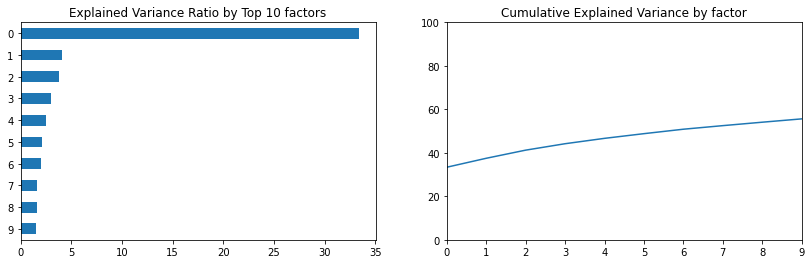

In [41]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

**Portfolio Weights**

In [42]:
def PCWeights():
    weights = pd.DataFrame()
    print(pca.components_[0])
    print(sum(pca.components_[0]))
    for i in range(len(pca.components_)):
      weights[i] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights

weights=PCWeights()

[-0.15975788 -0.15958162 -0.10653617 -0.13210519 -0.14298215 -0.12256982
 -0.13444601 -0.11334024 -0.14487368 -0.13148748 -0.1518397  -0.14852674
 -0.13573555 -0.13303511 -0.11814105 -0.16012827 -0.10603162 -0.11229356
 -0.13150286 -0.12444345 -0.12580995 -0.11410695 -0.13734927 -0.15620278
 -0.0990697  -0.1144994  -0.11855901 -0.11338335 -0.12598757 -0.09289441
 -0.10873879 -0.14756117 -0.10805012 -0.10545704 -0.11025769 -0.11726966
 -0.10536535 -0.10290216 -0.13429202 -0.10256337 -0.12965666 -0.10236737
 -0.14331562 -0.14546268 -0.12977404 -0.1040862  -0.10535094 -0.14059323
 -0.1263484  -0.11673833 -0.15373726 -0.1381239  -0.10308404 -0.11761951
 -0.1244523  -0.11643257 -0.12579729 -0.12741758 -0.14397649 -0.14707094
 -0.15006341 -0.09379362]
-7.794940323726624


In [43]:
NumComponents=10
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T

,Portfolio 0,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9
MMM,0.020,-0.689,0.114,-0.089,0.109,-0.751,0.080,-8.251,-0.536,-0.236
AXP,0.020,-0.129,-0.211,-0.128,-0.725,0.920,-0.156,-0.870,1.131,-0.032
AAPL,0.014,0.241,-0.997,0.247,0.333,1.627,0.110,-16.560,-1.750,-0.111
BA,0.017,-0.562,-0.015,-0.140,0.083,-1.641,-0.080,-26.996,-8.881,0.010
CAT,0.018,-0.746,-0.278,-0.297,0.278,-0.271,0.082,-2.066,-1.507,-0.035
...,...,...,...,...,...,...,...,...,...,...
TXN,0.016,0.077,-1.452,0.344,0.266,-0.580,0.064,2.812,3.934,0.074
UNP,0.018,-0.590,-0.066,-0.466,0.456,-3.573,-0.585,14.345,2.633,-0.184
UPS,0.019,-0.246,0.128,-0.175,0.071,-2.284,-0.157,1.287,1.790,-0.102
WFC,0.019,-0.496,-0.058,-0.299,-0.967,1.009,-0.073,-1.459,1.431,-0.167


**Sharpe Ratio**

In [44]:
# Sharpe Ratio
def sharpe_ratio(df, days_per_year=252):
    year = df.shape[0]/days_per_year

    annualized_return = np.power(np.prod(1+df),(1/year))-1

    annualized_vol = df.std() * np.sqrt(days_per_year)

    annualized_sharpe = annualized_return / annualized_vol

    return (annualized_return, annualized_vol, annualized_sharpe)

**Find Optimized Portfolio**

Eigen portfolio #0 with the highest Sharpe. Return 6.79%, vol = 12.80%, Sharpe = 0.53
    Return     Vol  Sharpe
0    0.068   0.128   0.531
14   0.360   0.703   0.513
6    0.147   0.663   0.221
3    0.059   0.424   0.139
23   0.102   1.016   0.101
48   0.048   0.961   0.050
19  -0.031   1.008  -0.030
7   -1.000  18.675  -0.054
55  -1.000  18.201  -0.055
22  -1.000  16.049  -0.062
56  -1.000  10.176  -0.098
39  -1.000   9.858  -0.101
45  -1.000   9.257  -0.108
20  -1.000   8.232  -0.121
49  -1.000   7.383  -0.135
59  -1.000   7.371  -0.136
8   -1.000   6.410  -0.156
42  -1.000   5.237  -0.191
46  -1.000   4.689  -0.213
53  -1.000   4.294  -0.233
33  -1.000   4.249  -0.235
52  -1.000   3.964  -0.252
9   -0.159   0.623  -0.256
36  -0.999   3.631  -0.275
37  -0.998   3.441  -0.290
34  -1.000   3.416  -0.293
24  -0.998   3.253  -0.307
41  -0.607   1.967  -0.309
57  -0.999   3.230  -0.309
21  -0.944   2.953  -0.320
25  -0.759   2.365  -0.321
35  -0.977   2.854  -0.342
32  -0.863   2.450  -0.

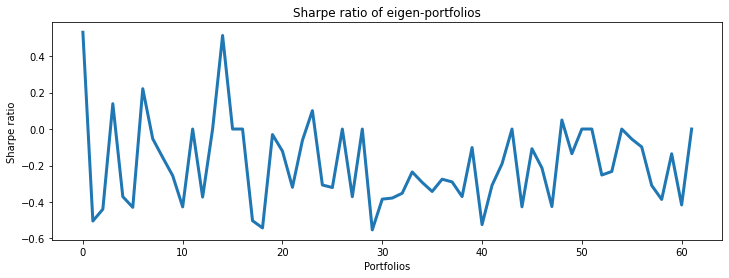

In [45]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        # each pc weights * 100, give stock code as index, and sort descending
        eigen_port = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_port.sort_values(by=['weights'], ascending=False, inplace=True)

        # X_train_raw = datareturns[:percentage]
        # sort stock returns based on its weight, dot each returns with its weight, give date as index
        eigen_port_returns = np.dot(X_train_raw.loc[:, eigen_port.index], pc_w)
        eigen_port_returns = pd.Series(eigen_port_returns.squeeze(), index=X_train_raw.index)

        er, vol, sharpe = sharpe_ratio(eigen_port_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results)

    plt.show()

optimizedPortfolio()

**Current Eigen Portfolio Weights**

[-0.15975788 -0.15958162 -0.10653617 -0.13210519 -0.14298215 -0.12256982
 -0.13444601 -0.11334024 -0.14487368 -0.13148748 -0.1518397  -0.14852674
 -0.13573555 -0.13303511 -0.11814105 -0.16012827 -0.10603162 -0.11229356
 -0.13150286 -0.12444345 -0.12580995 -0.11410695 -0.13734927 -0.15620278
 -0.0990697  -0.1144994  -0.11855901 -0.11338335 -0.12598757 -0.09289441
 -0.10873879 -0.14756117 -0.10805012 -0.10545704 -0.11025769 -0.11726966
 -0.10536535 -0.10290216 -0.13429202 -0.10256337 -0.12965666 -0.10236737
 -0.14331562 -0.14546268 -0.12977404 -0.1040862  -0.10535094 -0.14059323
 -0.1263484  -0.11673833 -0.15373726 -0.1381239  -0.10308404 -0.11761951
 -0.1244523  -0.11643257 -0.12579729 -0.12741758 -0.14397649 -0.14707094
 -0.15006341 -0.09379362]
-7.794940323726624


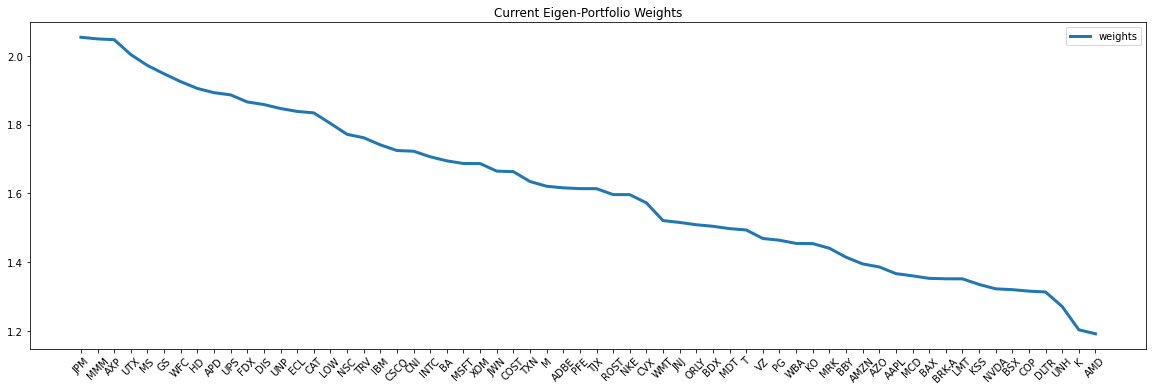

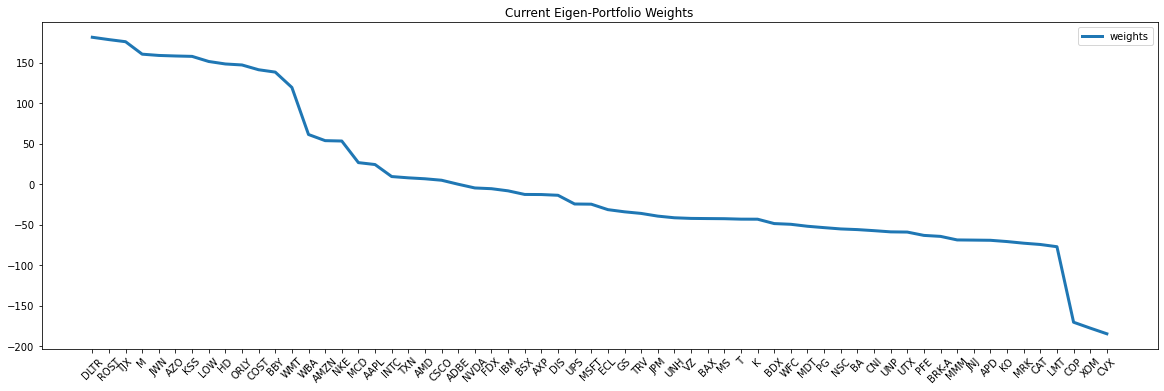

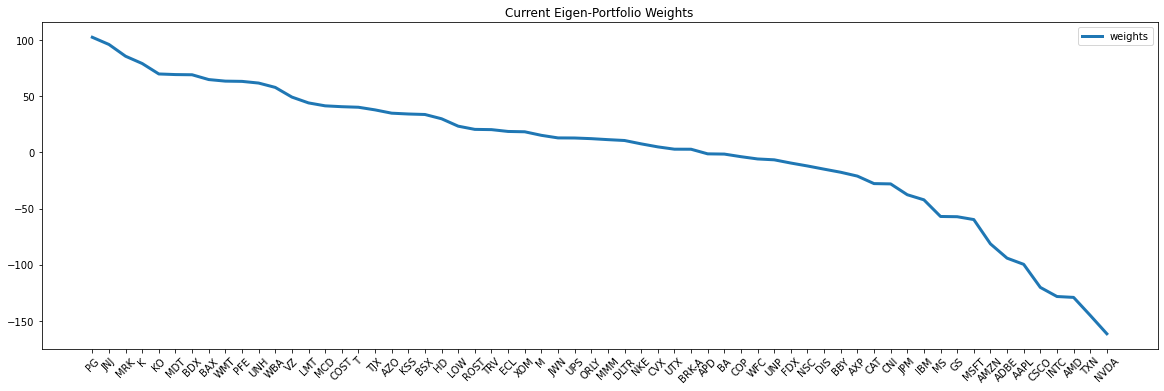

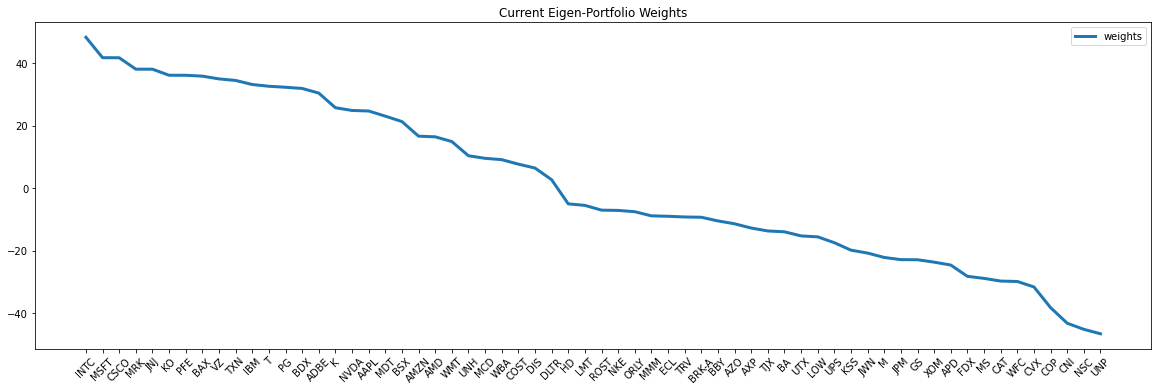

,weights
INTC,48.226
MSFT,41.698
CSCO,41.673
MRK,38.031
JNJ,38.014
...,...
CVX,-31.612
COP,-38.233
CNI,-43.217
NSC,-45.178


In [46]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(20,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights[0], plot=True)
plotEigen(weights[1], plot=True)
plotEigen(weights[2], plot=True)
plotEigen(weights[3], plot=True)

**Backtesting Eigen Portfolio**

[30, 7.774538034726097]
[23, 7.670499160204124]
[3, 5.770876096164082]
[6, 4.294520537693377]
[0, 3.193268674415509]
[14, 2.565189902484409]
[2, 2.319905136252646]
[58, 1.7493579333529254]
[9, 1.5133468566791843]
[18, 0.6539069319314421]
[48, 0.36803186877938865]
[37, 0.2890668480000716]
[27, 0.1224112934498968]
[38, 0.11066336848472406]
[47, 0.07742263155602887]
[4, -0.007460090698657006]
[17, -0.04074969352745828]
[25, -0.059633689171161144]
[51, -0.0683410511790479]
[22, -0.07301976463870423]
[54, -0.07696079800211558]
[56, -0.09138568920550798]
[45, -0.12470365473882128]
[24, -0.1357437384021368]
[49, -0.15200979534823456]
[15, -0.18457704603167233]
[28, -0.18604060883786033]
[32, -0.18994356685351216]
[8, -0.20695429846851449]
[43, -0.2118153275847121]
[16, -0.214942056775086]
[11, -0.21696585996635454]
[46, -0.2221315880760487]
[34, -0.2631968129140951]
[52, -0.2826573990420187]
[57, -0.2860123574829677]
[53, -0.2870671323193055]
[29, -0.29094760129413594]
[33, -0.291122321732849

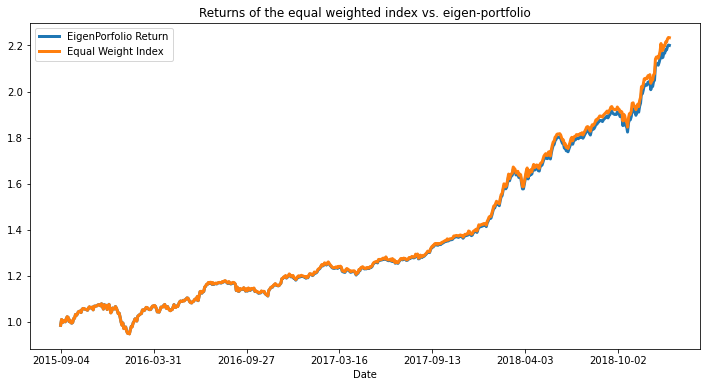

Current Eigen-Portfolio 30:
Return = 613.91%
Volatility = 78.96%
Sharpe = 7.77


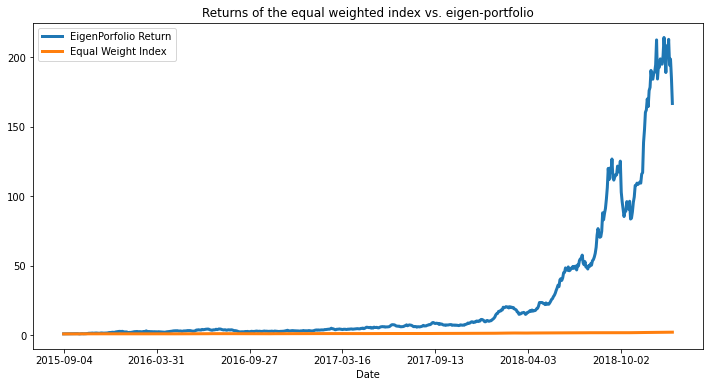

Current Eigen-Portfolio 23:
Return = 788.67%
Volatility = 102.82%
Sharpe = 7.67


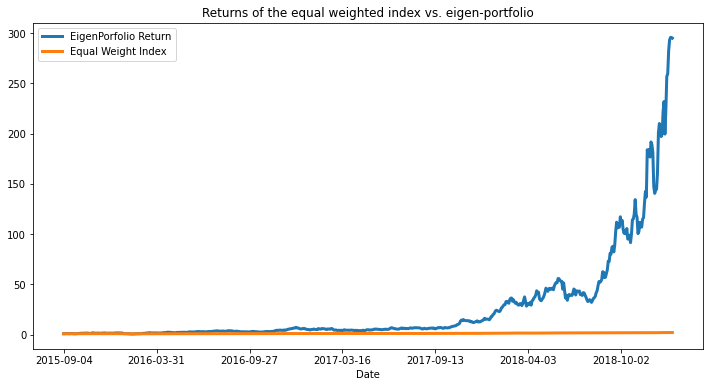

Current Eigen-Portfolio 3:
Return = 253.28%
Volatility = 43.89%
Sharpe = 5.77


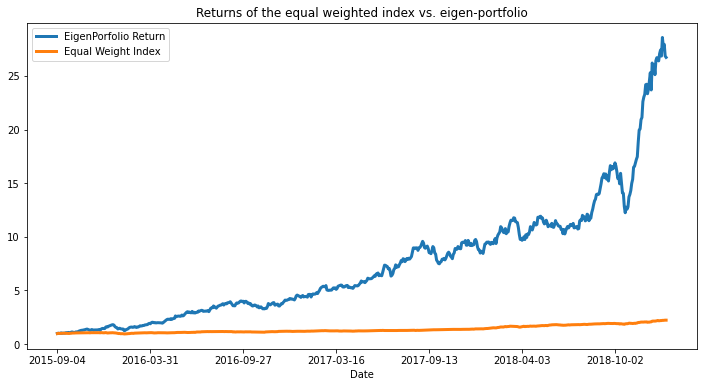

Current Eigen-Portfolio 6:
Return = 261.04%
Volatility = 60.78%
Sharpe = 4.29


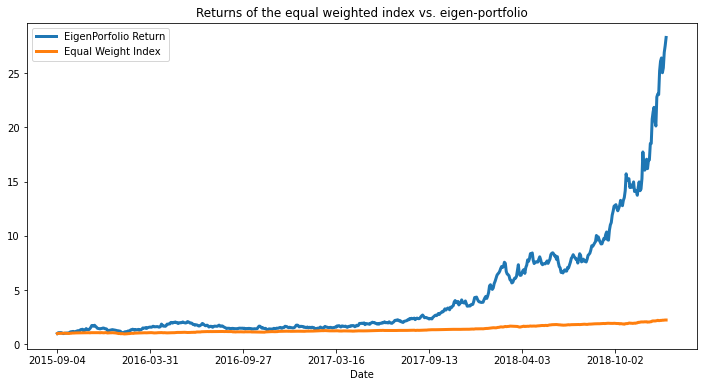

Current Eigen-Portfolio 14:
Return = 137.77%
Volatility = 53.71%
Sharpe = 2.57


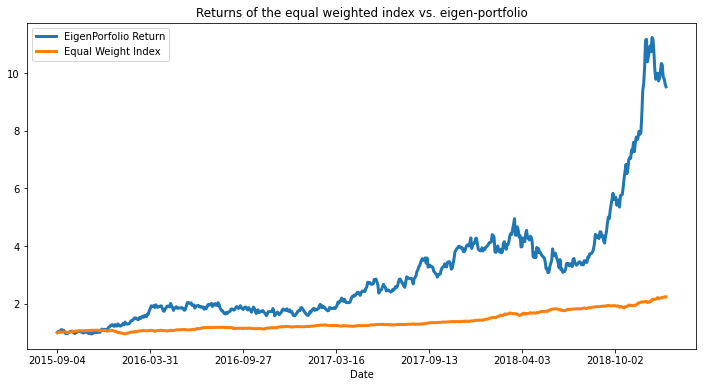

Current Eigen-Portfolio 2:
Return = 165.96%
Volatility = 71.54%
Sharpe = 2.32


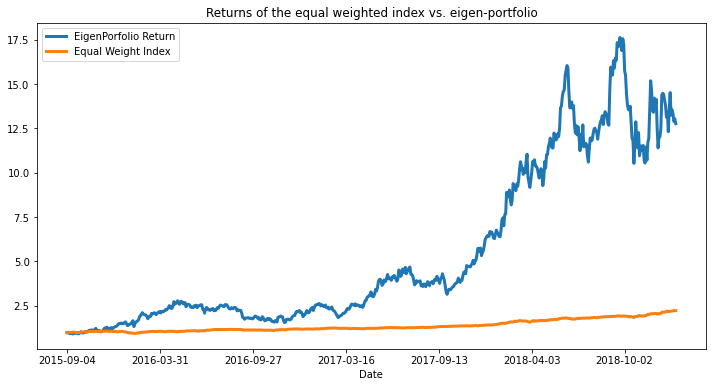

Current Eigen-Portfolio 58:
Return = 253.46%
Volatility = 144.89%
Sharpe = 1.75


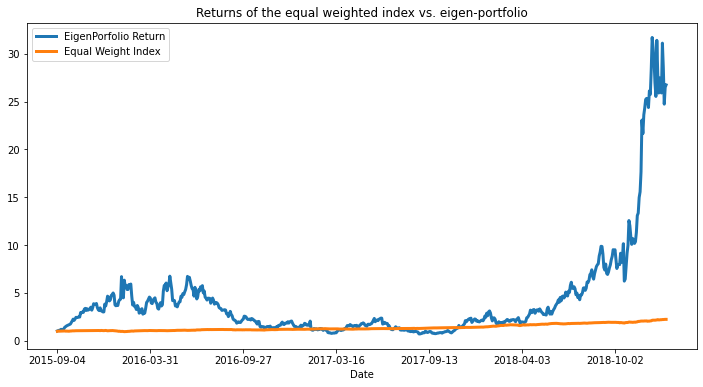

Current Eigen-Portfolio 9:
Return = 98.92%
Volatility = 65.36%
Sharpe = 1.51


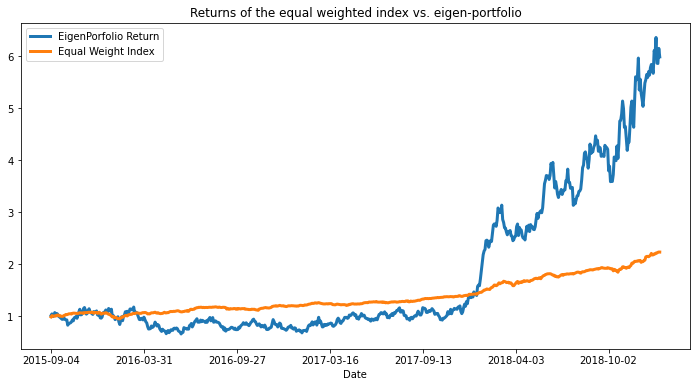

Current Eigen-Portfolio 44:
Return = -72.60%
Volatility = 146.91%
Sharpe = -0.49


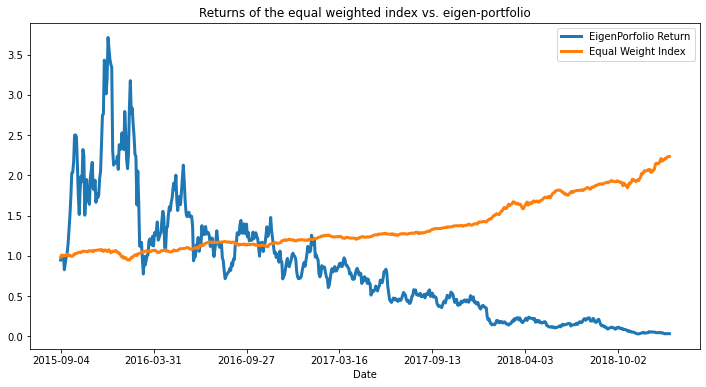

Current Eigen-Portfolio 41:
Return = -99.22%
Volatility = 179.23%
Sharpe = -0.55


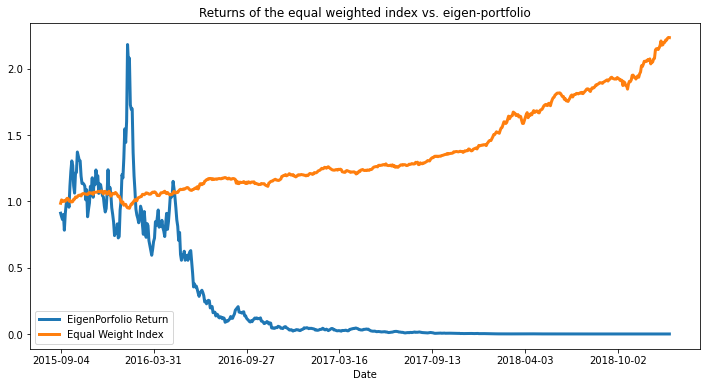

Current Eigen-Portfolio 1:
Return = -89.72%
Volatility = 134.93%
Sharpe = -0.66


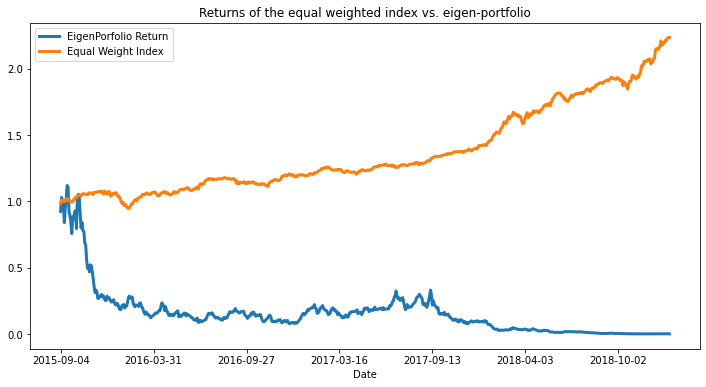

Current Eigen-Portfolio 12:
Return = -95.30%
Volatility = 139.18%
Sharpe = -0.68


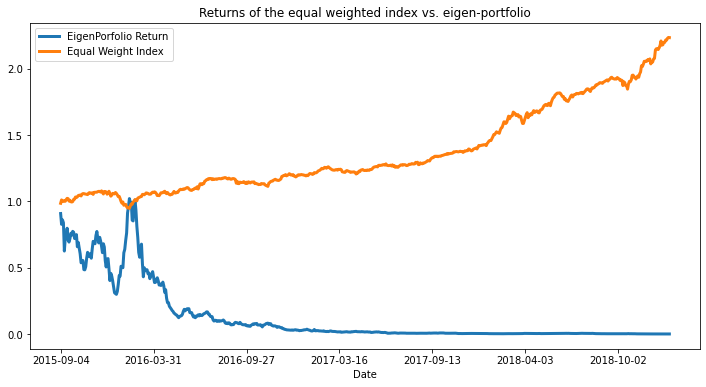

Current Eigen-Portfolio 19:
Return = -93.08%
Volatility = 91.48%
Sharpe = -1.02


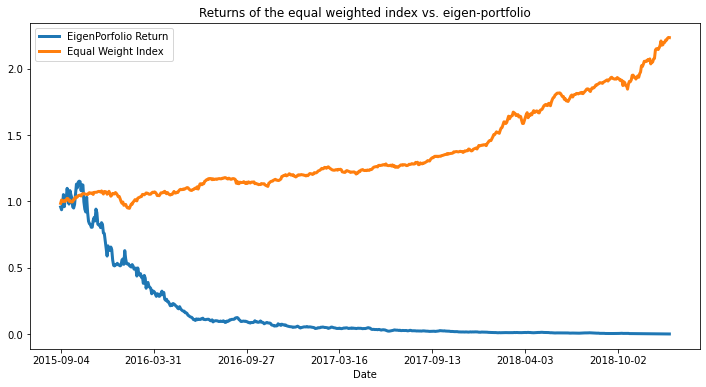

In [47]:
ranks = []
for i in range(62):
    eigen = weights[i]
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns) 
    if np.isnan(sharpe):
      continue
    ranks.append([i, sharpe])
ranks.sort(key=lambda x:x[1], reverse=True)
for i in range(len(ranks)):
    print(ranks[i])
def Backtest(eigen, num):
    # Plots Principle components returns against real returns
    
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio %d:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (num, returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , figsize=(12,6), linewidth=3)
    plt.show()

for i in [0,30,23,3,6,14,2,58,9,44,41,1,12,19]:
    Backtest(weights[i], i)